# Otter diet metabarcoding data processing

I will use [metaBEAT](https://github.com/HullUni-bioinformatics/metaBEAT), a tool tailored towards reproducible and efficient analyses of metabarcoding data that was developed by Christoph Hahn (University of Graz) for the EvoHull group at University of Hull. The pipeline is still under active development and will likely be extended further in the future. The pipeline is available in a Docker container with all necessary dependencies. The Docker image builds on [ReproPhylo](https://github.com/HullUni-bioinformatics/ReproPhylo).

The data I will be analyzing are 12S rRNA sequences amplified from otter spraint samples collected Tophill Low Nature Reserve. The experiment was designed to investigate what the otters are feeding on in the nature reserve.

The metaBEAT tool is designed for complete bioinformatic analysis from raw data, and performs (optionally) de-multiplexing, quality filtering, chimera detection, clustering, and taxononomic assignment (outputs in biom and tsv formats). It currently supports BLAST, Kraken and phylogenetic placement (pplacer). Further approaches will be included in the future to allow for efficient and standardized comparative assessments of all approaches. A large number of options are offered at each step of the pipeline to tailor bioinformatic analysis to different projects.

# Data input

This notebook will perform basic processing (trimming, merging, chimera removal, clustering and taxonomic assignment) of the metabarcoding data.

Minimum input for an analysis is a set of query sequences in one or several files (accepted are a number of file formats, e.g. fasta, fastq). These will be run through the pipeline sequentially.

Information on the nature and location of the query sequence files must be provided in a separate tab-delimited text file via the -Q flags.

Each line in this text file should look as follows: unique sample_ID, format, file1, file2

The required text files can be generated in any text editor. So theoretically, nano could be used in the terminal to construct the text file. For reproducibility and ease, a simple program can be used to generate the required file.

In the cell below, it is produced using a simple python script. The script will list all files in the location to which you've downloaded your Illumina data (specified via the 'datadir' variable). It assumes that there is a file ending in _R1.fastq for each sample. For each such file, it will extract the sample name from the filename and format the required line for the text file accordingly. The resulting file is called Querymap.txt (specified in the 'to' variable).

In [2]:
!pwd

/home/working


In [3]:
cd otter_metabarcoding/

/home/working/otter_metabarcoding


In [4]:
!mkdir 1-trimming

In [5]:
cd 1-trimming

/home/working/otter_metabarcoding/1-trimming


In [6]:
!ls -1 ../raw_reads/

LIB01-Negative-P01-B4.R1.fastq.gz
LIB01-Negative-P01-B4.R2.fastq.gz
LIB01-Positive-P01-A4.R1.fastq.gz
LIB01-Positive-P01-A4.R2.fastq.gz
LIB01-PS-Box01-T01.R1.fastq.gz
LIB01-PS-Box01-T01.R2.fastq.gz
LIB01-PS-Box01-T02.R1.fastq.gz
LIB01-PS-Box01-T02.R2.fastq.gz
LIB01-PS-Box01-T03.R1.fastq.gz
LIB01-PS-Box01-T03.R2.fastq.gz
LIB01-PS-Box01-T04.R1.fastq.gz
LIB01-PS-Box01-T04.R2.fastq.gz
LIB01-PS-Box01-T05.R1.fastq.gz
LIB01-PS-Box01-T05.R2.fastq.gz
LIB01-PS-Box01-T06.R1.fastq.gz
LIB01-PS-Box01-T06.R2.fastq.gz
LIB01-PS-Box01-T07.R1.fastq.gz
LIB01-PS-Box01-T07.R2.fastq.gz
LIB01-PS-Box01-T08.R1.fastq.gz
LIB01-PS-Box01-T08.R2.fastq.gz
LIB01-PS-Box01-T09.R1.fastq.gz
LIB01-PS-Box01-T09.R2.fastq.gz
LIB01-PS-Box01-T10.R1.fastq.gz
LIB01-PS-Box01-T10.R2.fastq.gz
LIB01-PS-Box01-T11.R1.fastq.gz
LIB01-PS-Box01-T11.R2.fastq.gz
LIB01-PS-Box01-T12.R1.fastq.gz
LIB01-PS-Box01-T12.R2.fastq.gz
LIB01-PS-Box02-T01.R1.fastq.gz
LIB01-PS-Box02-T01.R2.fastq.gz
LIB01-PS-Box02-T02.R1.fastq.gz
LIB01-PS-Box02-T02.R2.fastq

Prepare a text file specifying the samples to be processed including the format and location of the reads i.e. the querymap.

The next command expects two fastq files (forward and reverse reads) per sample in the directory ```../raw_reads/```. It expects the files to be named 'SampleID', followed by '_R1' or '_R2' to identify the forward/reverse read file respectively.

The raw data have been downloaded and demultiplexed. They can be found in `../raw_reads`.

SampleID must correspond to the first column in a file called `Sample_accessions.tsv`. This will either be pre-made to correspond to downloading read data from the NCBI Sequence Read Archive, or you will have to make it. The marker is '12S'.

If the `Sample_accessions.tsv` was pre-made, use this code to proceed:

In [7]:
#%%bash

#for a in $(cat ../Data/Sample_accessions.tsv | grep "12S" | cut -f 1 | grep "SampleID" -v)
#do
#    R1=$(ls -1 ../raw_reads/$a-12S_* | grep "_R1.fastq")
#    R2=$(ls -1 ../raw_reads/$a-12S_* | grep "_R2.fastq")
#
#    echo -e "$a\tfastq\t$R1\t$R2"
#done > Querymap.txt

In [8]:
#!head -n 10 Querymap.txt

**OR...**

To make the `Sample_accessions.tsv` file, use:

In [25]:
!echo "SampleID" > ../1-trimming/Sample_accessions.tsv

In [26]:
%%bash
for a in $(ls ../raw_reads/ | grep "R1" | cut -d '.' -f 1)
do 
   SampleID=$a
   
   echo -e "$SampleID"
done >> ../1-trimming/Sample_accessions.tsv

In [27]:
!cat ../1-trimming/Sample_accessions.tsv

SampleID
LIB01-Negative-P01-B4
LIB01-Positive-P01-A4
LIB01-PS-Box01-T01
LIB01-PS-Box01-T02
LIB01-PS-Box01-T03
LIB01-PS-Box01-T04
LIB01-PS-Box01-T05
LIB01-PS-Box01-T06
LIB01-PS-Box01-T07
LIB01-PS-Box01-T08
LIB01-PS-Box01-T09
LIB01-PS-Box01-T10
LIB01-PS-Box01-T11
LIB01-PS-Box01-T12
LIB01-PS-Box02-T01
LIB01-PS-Box02-T02
LIB01-PS-Box02-T03
LIB01-PS-Box02-T04
LIB01-PS-Box02-T05
LIB01-PS-Box02-T06
LIB01-PS-Box02-T07
LIB01-PS-Box02-T08
LIB01-PS-Box02-T09
LIB01-PS-Box02-T10
LIB01-PS-Box02-T11
LIB01-PS-Box02-T12
LIB02-TL01
LIB02-TL02
LIB02-TL03
LIB02-TL04
LIB02-TL05
LIB02-TL06
LIB02-TL07
LIB02-TL08
LIB02-TL09
LIB02-TL10
LIB02-TL11
LIB02-TL12
LIB02-TL13
LIB02-TL14
LIB02-TL15
LIB02-TL16
LIB02-TL17
LIB02-TL18
LIB02-TL20
LIB03-TL21
LIB03-TL23
LIB03-TL24
LIB03-TL25
LIB03-TL26
LIB03-TL27
LIB03-TL28
LIB03-TL29
LIB03-TL30
LIB03-TL31
LIB03-TL32
LIB03-TL33
LIB03-TL34
LIB03-TL35
LIB03-TL36
LIB03-TL38
LIB03-TL39
LIB03-TL40
LIB04-Negative-P02-D2
LIB04-Positive-P02-C2
LIB04-TL41
LIB04-TL42
LIB04-TL43
LIB04-T

In [35]:
%%bash

for a in $(cat ../1-trimming/Sample_accessions.tsv | grep "SampleID" -v)
do
    R1=$(ls -1 ../raw_reads/$a* | grep ".R1")
    R2=$(ls -1  ../raw_reads/$a* | grep ".R2")

    echo -e "$a\tfastq\t$R1\t$R2"
done > Querymap.txt

In [36]:
!head -n 10 Querymap.txt

LIB01-Negative-P01-B4	fastq	../raw_reads/LIB01-Negative-P01-B4.R1.fastq.gz	../raw_reads/LIB01-Negative-P01-B4.R2.fastq.gz
LIB01-Positive-P01-A4	fastq	../raw_reads/LIB01-Positive-P01-A4.R1.fastq.gz	../raw_reads/LIB01-Positive-P01-A4.R2.fastq.gz
LIB01-PS-Box01-T01	fastq	../raw_reads/LIB01-PS-Box01-T01.R1.fastq.gz	../raw_reads/LIB01-PS-Box01-T01.R2.fastq.gz
LIB01-PS-Box01-T02	fastq	../raw_reads/LIB01-PS-Box01-T02.R1.fastq.gz	../raw_reads/LIB01-PS-Box01-T02.R2.fastq.gz
LIB01-PS-Box01-T03	fastq	../raw_reads/LIB01-PS-Box01-T03.R1.fastq.gz	../raw_reads/LIB01-PS-Box01-T03.R2.fastq.gz
LIB01-PS-Box01-T04	fastq	../raw_reads/LIB01-PS-Box01-T04.R1.fastq.gz	../raw_reads/LIB01-PS-Box01-T04.R2.fastq.gz
LIB01-PS-Box01-T05	fastq	../raw_reads/LIB01-PS-Box01-T05.R1.fastq.gz	../raw_reads/LIB01-PS-Box01-T05.R2.fastq.gz
LIB01-PS-Box01-T06	fastq	../raw_reads/LIB01-PS-Box01-T06.R1.fastq.gz	../raw_reads/LIB01-PS-Box01-T06.R2.fastq.gz
LIB01-PS-Box01-T07	fastq	../raw_reads/LIB01-PS-Box01-T07.R1.fastq.gz	../raw_re

To the `Querymap.txt` file, add two columns which specify the number of bases to remove from the forward and reverse read. In our case, we want to remove 18 bp to ensure that their is no forward or reverse primer left.

In [37]:
%%bash

sed 's/$/&\t18/' Querymap.txt > Querymap_new.txt

Have a look (note that the output is probably line-wrapped):

In [38]:
!head -n 4 Querymap_new.txt

LIB01-Negative-P01-B4	fastq	../raw_reads/LIB01-Negative-P01-B4.R1.fastq.gz	../raw_reads/LIB01-Negative-P01-B4.R2.fastq.gz	18
LIB01-Positive-P01-A4	fastq	../raw_reads/LIB01-Positive-P01-A4.R1.fastq.gz	../raw_reads/LIB01-Positive-P01-A4.R2.fastq.gz	18
LIB01-PS-Box01-T01	fastq	../raw_reads/LIB01-PS-Box01-T01.R1.fastq.gz	../raw_reads/LIB01-PS-Box01-T01.R2.fastq.gz	18
LIB01-PS-Box01-T02	fastq	../raw_reads/LIB01-PS-Box01-T02.R1.fastq.gz	../raw_reads/LIB01-PS-Box01-T02.R2.fastq.gz	18


In [39]:
%%bash

sed 's/$/&\t18/' Querymap_new.txt > Querymap_final.txt

In [40]:
!head -n 4 Querymap_final.txt

LIB01-Negative-P01-B4	fastq	../raw_reads/LIB01-Negative-P01-B4.R1.fastq.gz	../raw_reads/LIB01-Negative-P01-B4.R2.fastq.gz	18	18
LIB01-Positive-P01-A4	fastq	../raw_reads/LIB01-Positive-P01-A4.R1.fastq.gz	../raw_reads/LIB01-Positive-P01-A4.R2.fastq.gz	18	18
LIB01-PS-Box01-T01	fastq	../raw_reads/LIB01-PS-Box01-T01.R1.fastq.gz	../raw_reads/LIB01-PS-Box01-T01.R2.fastq.gz	18	18
LIB01-PS-Box01-T02	fastq	../raw_reads/LIB01-PS-Box01-T02.R1.fastq.gz	../raw_reads/LIB01-PS-Box01-T02.R2.fastq.gz	18	18


# Raw read processing

Now, perform basic quality trimming and clipping (Trimmomatic) and paired-end read merging (flash). metaBEAT will be used to process all samples in one go.

In [41]:
!metaBEAT_global.py -h

usage: metaBEAT.py [-h] [-Q <FILE>] [-B <FILE>] [--g_queries <FILE>] [-v] [-s]
                   [-f] [-p] [-k] [-t] [-b] [-m <string>] [-n <INT>] [-E] [-e]
                   [--read_stats_off] [--PCR_primer <FILE>] [--bc_dist <INT>]
                   [--trim_adapter <FILE>] [--trim_qual <INT>] [--phred <INT>]
                   [--trim_window <INT>] [--read_crop <INT>]
                   [--trim_minlength <INT>] [--merge] [--product_length <INT>]
                   [--merged_only] [--forward_only] [--length_filter <INT>]
                   [--length_deviation <FLOAT>] [-R <FILE>] [--gb_out <FILE>]
                   [--rec_check] [--gb_to_taxid <FILE>] [--cluster]
                   [--clust_match <FLOAT>] [--clust_cov <INT>]
                   [--blast_db <PATH>] [--blast_xml <PATH>]
                   [--update_taxonomy] [--taxonomy_db <FILE>]
                   [--min_ident <FLOAT>] [--min_ali_length <FLOAT>]
                   [--bitscore_skim_LCA <FLOAT>] [--bitscore_skim_adju

Command to trim:

In [42]:
%%bash

metaBEAT_global.py \
-Q Querymap_final.txt \
--trim_qual 30 --read_crop 110 --trim_minlength 90 \
--merge --product_length 110 --forward_only --length_filter 100 \
-@ L.Harper@2015.hull.ac.uk \
-n 5 -v &> log 

Read processing will take several hours.


# Visualise query survival after trimming

metaBEAT will generate a directory with all temporary files that were created during the processing for each sample and will record useful stats summarizing the data processing in the file `metaBEAT_read_stats.csv`. You can explore the table manually or quickly plot out some of these stats here:

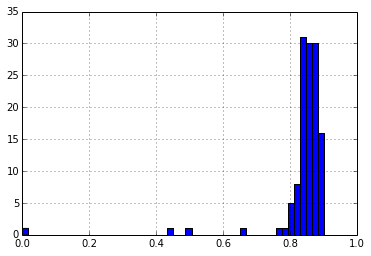

In [43]:
%matplotlib inline
import pandas as pd

df = pd.read_csv('metaBEAT_read_stats.csv',index_col=0)
df['fraction'] = df['queries']/(df['total']*0.5)
df.fraction.hist(bins=50)

Detailed information on what metaBEAT did to each sample is contained in the `log` file. It contains the exact commands that were run for each sample during each step of the process.

In [45]:
!head -n 50 log


metaBEAT - metaBarcoding and Environmental DNA Analyses tool
version: v.0.97.11-global


Fri Feb 23 14:50:53 2018

/usr/bin/metaBEAT_global.py -Q Querymap_final.txt --trim_qual 30 --read_crop 110 --trim_minlength 90 --merge --product_length 110 --forward_only --length_filter 100 -@ L.Harper@2015.hull.ac.uk -n 5 -v


metaBEAT may be querying NCBI's Entrez databases to fetch/verify taxonomic ids. Entrez User requirements state that you need to identify yourself by providing an email address so that NCBI can contact you in case there is a problem.

You have specified: 'L.Harper@2015.hull.ac.uk'


Parsing querylist file

Number of samples to process: 129
Sequence input format: defaultdict(<type 'int'>, {'fastq': 129})
Barcodes for demultiplexing provided for 0 samples
Cropping instructions provided for 129 samples


Fri Feb 23 14:50:53 2018


##### processing query ID: LIB01-Negative-P01-B4 #####


### READ QUALITY TRIMMING ###


trimming PE reads with trimmomatic
java -jar /usr/bin/trimm

The next steps in the processing will be chimera detection, and global clustering of the centroids from all clusters from all samples to produce denovo OTUs. The temporary files from the global clustering and the final OTU table were written to the directory `./GLOBAL`.

In [44]:
!ls GLOBAL/

global_centroids.fasta	global.uc		  metaBEAT-OTU-denovo.tsv
global_queries.fasta	metaBEAT-OTU-denovo.biom


The denovo OTU table (numbers are reads) can be viewed to see how OTUs are distributed across your samples. 

# Chimera detection

Some stats on the read counts before/after trimming, merging etc. are summarized for you in `metaBEAT_read_stats.csv`.

Next stage of the processing is chimera detection and removal of putative chimeric sequences. We'll do that using uchime as implemented in vsearch.

In [46]:
!pwd

/home/working/otter_metabarcoding/1-trimming


In [47]:
cd ../

/home/working/otter_metabarcoding


In [48]:
!mkdir 2-chimera_detection

In [49]:
cd 2-chimera_detection

/home/working/otter_metabarcoding/2-chimera_detection


Convert reference database from GenBank to fasta format to be used in chimera detection.

Prepare `REFmap.txt` file, i.e. text file that specifies the location and the format of the reference to be used.
The reference sequences in GenBank format are present in subdirectories for each vertebrate group in the `../Reference_database` directory.

In [58]:
!echo '../Reference_database/Amphibians/12S_UKamphibians_SATIVA_cleaned.gb\tgb\n' \
'../Reference_database/Reptiles/12S_UKreptiles_SATIVA_cleaned.gb\tgb\n' \
'../Reference_database/Mammals/12S_UKmammals_SATIVA_cleaned.gb\tgb\n' \
'../Reference_database/Birds/12S_UKbirds_SATIVA_cleaned.gb\tgb\n' \
'../Reference_database/Fish/12S_Fish_SATIVA_cleaned_May_2017.gb\tgb\n' \
'../Reference_database/Fish/Astatotilapia_calliptera.gb\tgb\n' \
'../Reference_database/Fish/RhamphochromisEsox_mt.gb\tgb\n' \
'../Reference_database/Fish/M.zebra.gb\tgb'> REFmap.txt

In [59]:
!cat REFmap.txt

../Reference_database/Amphibians/12S_UKamphibians_SATIVA_cleaned.gb	gb
 ../Reference_database/Reptiles/12S_UKreptiles_SATIVA_cleaned.gb	gb
 ../Reference_database/Mammals/12S_UKmammals_SATIVA_cleaned.gb	gb
 ../Reference_database/Birds/12S_UKbirds_SATIVA_cleaned.gb	gb
 ../Reference_database/Fish/12S_Fish_SATIVA_cleaned_May_2017.gb	gb
 ../Reference_database/Fish/Astatotilapia_calliptera.gb	gb
 ../Reference_database/Fish/RhamphochromisEsox_mt.gb	gb
 ../Reference_database/Fish/M.zebra.gb	gb


In [60]:
!metaBEAT_global.py -h

usage: metaBEAT.py [-h] [-Q <FILE>] [-B <FILE>] [--g_queries <FILE>] [-v] [-s]
                   [-f] [-p] [-k] [-t] [-b] [-m <string>] [-n <INT>] [-E] [-e]
                   [--read_stats_off] [--PCR_primer <FILE>] [--bc_dist <INT>]
                   [--trim_adapter <FILE>] [--trim_qual <INT>] [--phred <INT>]
                   [--trim_window <INT>] [--read_crop <INT>]
                   [--trim_minlength <INT>] [--merge] [--product_length <INT>]
                   [--merged_only] [--forward_only] [--length_filter <INT>]
                   [--length_deviation <FLOAT>] [-R <FILE>] [--gb_out <FILE>]
                   [--rec_check] [--gb_to_taxid <FILE>] [--cluster]
                   [--clust_match <FLOAT>] [--clust_cov <INT>]
                   [--blast_db <PATH>] [--blast_xml <PATH>]
                   [--update_taxonomy] [--taxonomy_db <FILE>]
                   [--min_ident <FLOAT>] [--min_ali_length <FLOAT>]
                   [--bitscore_skim_LCA <FLOAT>] [--bitscore_skim_adju

In [61]:
%%bash

metaBEAT_global.py \
-R REFmap.txt \
-f \
-@ L.Harper@2015.hull.ac.uk


metaBEAT - metaBarcoding and Environmental DNA Analyses tool
version: v.0.97.11-global


Fri Feb 23 17:43:24 2018

/usr/bin/metaBEAT_global.py -R REFmap.txt -f -@ L.Harper@2015.hull.ac.uk


metaBEAT may be querying NCBI's Entrez databases to fetch/verify taxonomic ids. Entrez User requirements state that you need to identify yourself by providing an email address so that NCBI can contact you in case there is a problem.

You have specified: 'L.Harper@2015.hull.ac.uk'


######## PROCESSING REFERENCE DATA ########


processing ../Reference_database/Fish/RhamphochromisEsox_mt.gb (containing 1 records)

total number of valid records: 1


processing ../Reference_database/Mammals/12S_UKmammals_SATIVA_cleaned.gb (containing 1046 records)

total number of valid records: 1047


processing ../Reference_database/Birds/12S_UKbirds_SATIVA_cleaned.gb (containing 622 records)

total number of valid records: 1669


processing ../Reference_database/Amphibians/12S_UKamphibians_SATIVA_cleaned.gb (contain

Traceback (most recent call last):
  File "/usr/bin/metaBEAT_global.py", line 2575, in <module>
    out.write(BIOM_tables_per_method['OTU_denovo'].to_tsv()) #to_json('generaged by test', direct_io=out)
  File "/usr/local/lib/python2.7/dist-packages/biom/table.py", line 4027, in to_tsv
    observation_column_name)
  File "/usr/local/lib/python2.7/dist-packages/biom/table.py", line 1268, in delimited_self
    raise TableException("Cannot delimit self if I don't have data...")
biom.exception.TableException: Cannot delimit self if I don't have data...


This will produce `refs.fasta`.

In [62]:
!head refs.fasta

>NC_018563|163638|Rhamphochromis esox
GCTAGCGTAGCTTAACTAAAGCATAACACTGAAGATGTTAAGACGGTCCCTAGAAAGGTCCCGTGAGCACAAAGGCTTGGTCCTGACTTTACTGTCAACTTTGGCTAAACTTACACATGCAAGTCTCCGCCCCCCTGTGAGAATGCCCACAGTTTTCTGCCCGAAAACAAGGAGCTGGTATCAGGCACACTTTCCGCAGCCCATGACACCTTGCTTAGCCACACCCTCAAGGGAACTCAGCAGTGATAGACATTAAGCCATAAGTGAAAGCTTGACTTAGTTAAAGCCAAGAGGGCCGGTAAAACTCGTGCCAGCCACCGCGGTTATACGAGAGGCTCAAGTTGACAGACATCGGCGTAAAGGGTGGTTAGGAAGTTTTTAAACTAAAGCCGAACGCCCTCAGAACTGTTATACGTACCCGAGAGCAAGAAGCCCCACTACGAAAGTGGCTTTATATCCCCGACCCCACGAAAGCTGCGAAACAAACTGGGATTAGATACCCCACTATGCCCAGCCCTAAACCTTGATAGCCCCCTACACCCACTATCCGCCCGGGTACTACGAGCACTAGCTTAAAACCCAAAGGACTTGGCGGTGCTTTATATCCACCTAGAGGAGCCTGTTCTAGAACCGATAACCCCCGTTAAACCTCACCCCCTCTTGTTCTTCCCGTCTATATACCGCCGTCGTCAGCTTACCCTATGAAGGAACCACAGTAAGCAAAACTAGTACAACTCAAAACGCCAGGTCGAGGTGTAGCATATGAGGGGGGAAGAAATGAGCTACATTCCCTGCCACAGGGAATACGAACAATGTAATGAAATACACATTAGAAGGAGGATTTAGCAGTAAGCAGAAAATAGAGCGTTCCGCTGAAATTGGCCCTGAAGCGCGCACACACCGCCCGTCACTCTCCCCAAGCCAACAACATCCTATAAATAATATATTTTACCGGTAAAGGG

Now run chimera detection.

In [63]:
%%bash


for a in $(cut -f 1 ../1-trimming/Querymap.txt)
do
    if [ -s ../1-trimming/$a/$a\_trimmed.fasta ]
    then
        echo -e "\n### Detecting chimeras in $a ###\n"
        mkdir $a
        cd $a
        vsearch --uchime_ref ../../1-trimming/$a/$a\_trimmed.fasta --db ../refs.fasta \
        --nonchimeras $a-nonchimeras.fasta --chimeras $a-chimeras.fasta &> log 
        cd ..

    else
        echo -e "$a is empty"
    fi
done


### Detecting chimeras in LIB01-Negative-P01-B4 ###


### Detecting chimeras in LIB01-Positive-P01-A4 ###


### Detecting chimeras in LIB01-PS-Box01-T01 ###


### Detecting chimeras in LIB01-PS-Box01-T02 ###


### Detecting chimeras in LIB01-PS-Box01-T03 ###


### Detecting chimeras in LIB01-PS-Box01-T04 ###


### Detecting chimeras in LIB01-PS-Box01-T05 ###


### Detecting chimeras in LIB01-PS-Box01-T06 ###


### Detecting chimeras in LIB01-PS-Box01-T07 ###


### Detecting chimeras in LIB01-PS-Box01-T08 ###


### Detecting chimeras in LIB01-PS-Box01-T09 ###


### Detecting chimeras in LIB01-PS-Box01-T10 ###


### Detecting chimeras in LIB01-PS-Box01-T11 ###


### Detecting chimeras in LIB01-PS-Box01-T12 ###


### Detecting chimeras in LIB01-PS-Box02-T01 ###


### Detecting chimeras in LIB01-PS-Box02-T02 ###


### Detecting chimeras in LIB01-PS-Box02-T03 ###


### Detecting chimeras in LIB01-PS-Box02-T04 ###


### Detecting chimeras in LIB01-PS-Box02-T05 ###


### Detecting chimeras i

# Clustering and taxonomic assignment

In [64]:
!pwd

/home/working/otter_metabarcoding/2-chimera_detection


In [65]:
cd ..

/home/working/otter_metabarcoding


In [66]:
!mkdir 3-taxonomic_assignment

In [67]:
cd 3-taxonomic_assignment/

/home/working/otter_metabarcoding/3-taxonomic_assignment


Produce the text file containing the reference sequences using the command line - we call it `REFmap.txt`.

In [68]:
!echo '../Reference_database/Amphibians/12S_UKamphibians_SATIVA_cleaned.gb\tgb\n' \
'../Reference_database/Reptiles/12S_UKreptiles_SATIVA_cleaned.gb\tgb\n' \
'../Reference_database/Mammals/12S_UKmammals_SATIVA_cleaned.gb\tgb\n' \
'../Reference_database/Birds/12S_UKbirds_SATIVA_cleaned.gb\tgb\n' \
'../Reference_database/Fish/12S_Fish_SATIVA_cleaned_May_2017.gb\tgb\n' \
'../Reference_database/Fish/Astatotilapia_calliptera.gb\tgb\n' \
'../Reference_database/Fish/RhamphochromisEsox_mt.gb\tgb\n' \
'../Reference_database/Fish/M.zebra.gb\tgb'> REFmap.txt

In [69]:
!cat REFmap.txt

../Reference_database/Amphibians/12S_UKamphibians_SATIVA_cleaned.gb	gb
 ../Reference_database/Reptiles/12S_UKreptiles_SATIVA_cleaned.gb	gb
 ../Reference_database/Mammals/12S_UKmammals_SATIVA_cleaned.gb	gb
 ../Reference_database/Birds/12S_UKbirds_SATIVA_cleaned.gb	gb
 ../Reference_database/Fish/12S_Fish_SATIVA_cleaned_May_2017.gb	gb
 ../Reference_database/Fish/Astatotilapia_calliptera.gb	gb
 ../Reference_database/Fish/RhamphochromisEsox_mt.gb	gb
 ../Reference_database/Fish/M.zebra.gb	gb


Produce the text file containing non-chimera query sequences - `Querymap.txt`.

In [70]:
%%bash

#Querymap
for a in $(ls -l ../2-chimera_detection/ | grep "^d" | perl -ne 'chomp; @a=split(" "); print "$a[-1]\n"')
do
    echo -e "$a-nc\tfasta\t../2-chimera_detection/$a/$a-nonchimeras.fasta"
done > Querymap.txt

In [71]:
!cat Querymap.txt

GLOBAL-nc	fasta	../2-chimera_detection/GLOBAL/GLOBAL-nonchimeras.fasta
LIB01-Negative-P01-B4-nc	fasta	../2-chimera_detection/LIB01-Negative-P01-B4/LIB01-Negative-P01-B4-nonchimeras.fasta
LIB01-Positive-P01-A4-nc	fasta	../2-chimera_detection/LIB01-Positive-P01-A4/LIB01-Positive-P01-A4-nonchimeras.fasta
LIB01-PS-Box01-T01-nc	fasta	../2-chimera_detection/LIB01-PS-Box01-T01/LIB01-PS-Box01-T01-nonchimeras.fasta
LIB01-PS-Box01-T02-nc	fasta	../2-chimera_detection/LIB01-PS-Box01-T02/LIB01-PS-Box01-T02-nonchimeras.fasta
LIB01-PS-Box01-T03-nc	fasta	../2-chimera_detection/LIB01-PS-Box01-T03/LIB01-PS-Box01-T03-nonchimeras.fasta
LIB01-PS-Box01-T04-nc	fasta	../2-chimera_detection/LIB01-PS-Box01-T04/LIB01-PS-Box01-T04-nonchimeras.fasta
LIB01-PS-Box01-T05-nc	fasta	../2-chimera_detection/LIB01-PS-Box01-T05/LIB01-PS-Box01-T05-nonchimeras.fasta
LIB01-PS-Box01-T06-nc	fasta	../2-chimera_detection/LIB01-PS-Box01-T06/LIB01-PS-Box01-T06-nonchimeras.fasta
LIB01-PS-Box01-T07-nc	fasta	../2-chimera_detection/LIB0

The Querymap.txt file has been made but includes the `./GLOBAL` directory in which all centroids and queries are contained. This will cause metaBEAT to fail so it must be removed manually from the `Querymap.txt` file.

In [72]:
!sed '/GLOBAL/d' Querymap.txt > Querymap_final.txt

In [73]:
!cat Querymap_final.txt

LIB01-Negative-P01-B4-nc	fasta	../2-chimera_detection/LIB01-Negative-P01-B4/LIB01-Negative-P01-B4-nonchimeras.fasta
LIB01-Positive-P01-A4-nc	fasta	../2-chimera_detection/LIB01-Positive-P01-A4/LIB01-Positive-P01-A4-nonchimeras.fasta
LIB01-PS-Box01-T01-nc	fasta	../2-chimera_detection/LIB01-PS-Box01-T01/LIB01-PS-Box01-T01-nonchimeras.fasta
LIB01-PS-Box01-T02-nc	fasta	../2-chimera_detection/LIB01-PS-Box01-T02/LIB01-PS-Box01-T02-nonchimeras.fasta
LIB01-PS-Box01-T03-nc	fasta	../2-chimera_detection/LIB01-PS-Box01-T03/LIB01-PS-Box01-T03-nonchimeras.fasta
LIB01-PS-Box01-T04-nc	fasta	../2-chimera_detection/LIB01-PS-Box01-T04/LIB01-PS-Box01-T04-nonchimeras.fasta
LIB01-PS-Box01-T05-nc	fasta	../2-chimera_detection/LIB01-PS-Box01-T05/LIB01-PS-Box01-T05-nonchimeras.fasta
LIB01-PS-Box01-T06-nc	fasta	../2-chimera_detection/LIB01-PS-Box01-T06/LIB01-PS-Box01-T06-nonchimeras.fasta
LIB01-PS-Box01-T07-nc	fasta	../2-chimera_detection/LIB01-PS-Box01-T07/LIB01-PS-Box01-T07-nonchimeras.fasta
LIB01-PS-Box01-T08-

That's almost it. Now start the pipeline to do sequence clustering and taxonomic assignment of non-chimera queries via metaBEAT. As input, `Querymap.txt` containing samples that have been trimmed, merged and checked for chimeras, and the `REFmap.txt file` must be specified. metaBEAT will be asked to attempt taxonomic assignment using BLAST.

metaBEAT will automatically wrangle the data into the particular file formats that are required by each of the methods, run all necessary steps, and finally convert the outputs of each program to a standardized BIOM table.

GO!

In [74]:
!metaBEAT_global.py -h

usage: metaBEAT.py [-h] [-Q <FILE>] [-B <FILE>] [--g_queries <FILE>] [-v] [-s]
                   [-f] [-p] [-k] [-t] [-b] [-m <string>] [-n <INT>] [-E] [-e]
                   [--read_stats_off] [--PCR_primer <FILE>] [--bc_dist <INT>]
                   [--trim_adapter <FILE>] [--trim_qual <INT>] [--phred <INT>]
                   [--trim_window <INT>] [--read_crop <INT>]
                   [--trim_minlength <INT>] [--merge] [--product_length <INT>]
                   [--merged_only] [--forward_only] [--length_filter <INT>]
                   [--length_deviation <FLOAT>] [-R <FILE>] [--gb_out <FILE>]
                   [--rec_check] [--gb_to_taxid <FILE>] [--cluster]
                   [--clust_match <FLOAT>] [--clust_cov <INT>]
                   [--blast_db <PATH>] [--blast_xml <PATH>]
                   [--update_taxonomy] [--taxonomy_db <FILE>]
                   [--min_ident <FLOAT>] [--min_ali_length <FLOAT>]
                   [--bitscore_skim_LCA <FLOAT>] [--bitscore_skim_adju

In [75]:
%%bash

metaBEAT_global.py \
-Q Querymap_final.txt \
-R REFmap.txt \
--cluster --clust_match 1 --clust_cov 3 \
--blast --min_ident 0.98 --min_ali_length 0.8 \
-m 12S -n 5 \
-E -v \
-@ L.Harper@2015.hull.ac.uk \
-o 12S-trim30_crop110_min90_merge-forwonly_nonchimera_c1cov3_blast98-id1 &> log98

In [76]:
!tail -n 50 log98

assigned LCA Anguilla anguilla (taxid 7936) at level species

attempting LCA assignment for LIB06-MH-19-02-nc|M04282:61:000000000-BHMW4:1:1109:9643:18884_ex
found LCA 9823 at level species
assigned LCA Sus scrofa (taxid 9823) at level species

attempting LCA assignment for LIB03-TL24-nc|M04282:61:000000000-BHMW4:1:1108:9804:14414_ex
found LCA 69291 at level family
assigned LCA Gasterosteidae (taxid 69291) at level family

direct assignment for LIB07-01-08-nc|M04282:61:000000000-BHMW4:1:2103:21686:16509_ex -> 161648

attempting LCA assignment for LIB06-MH-19-06-nc|M04282:61:000000000-BHMW4:1:2102:22896:16288_ex
found LCA 9159 at level genus
assigned LCA Passer (taxid 9159) at level genus

attempting LCA assignment for LIB04-TL47-nc|M04282:61:000000000-BHMW4:1:1104:14202:16519_ex
found LCA 7953 at level family
assigned LCA Cyprinidae (taxid 7953) at level family

attempting LCA assignment for LIB06-MH-19-01-nc|M04282:61:000000000-BHMW4:1:1101:10002:3704_ex
found LCA 9072 at level subfami

It is important to know the identity of unassigned reads for contamination or reference database ambiguities. This code will BLAST unassigned reads against the entirety of GenBank.

Based on the results of the 98% BLAST identity metaBEAT run, a new BIOM table containing only OTUs that were not taxonomically assigned is generated. A fasta file with the corresponding sequences is also prepared.

Required files:

fasta file containing all query sequences (global centroids), as produced by 98% identity metaBEAT run

taxonomy annotated OTU biom table in json format from a metaBEAT run. Not the taxonomy collapsed BIOM table.

Load the necessary functions. Functions are in place as of version '0.97.4-global' (commit: 9110e5a3f4a979e85733f83cb0388b00586544f6).

In [1]:
!pwd

/home/working/otter_metabarcoding


In [2]:
!mkdir 4-unassigned

In [3]:
cd 4-unassigned/

/home/working/otter_metabarcoding/4-unassigned


In [4]:
import metaBEAT_global_misc_functions as mb

Read in `OTU-taxonomy.blast.biom` file from original metaBEAT analysis.

In [6]:
table = mb.load_BIOM('../3-taxonomic_assignment/GLOBAL/BLAST_0.98/12S-trim30_crop110_min90_merge-forwonly_nonchimera_c1cov3_blast98-id1-OTU-taxonomy.blast.biom', 
                     informat='json')


Specified BIOM input format 'json' - ok!


In [8]:
# double check that we've got a table
print table

# Constructed from biom file
#OTU ID	LIB01-Negative-P01-B4-nc.blast	LIB01-PS-Box01-T01-nc.blast	LIB01-PS-Box01-T02-nc.blast	LIB01-PS-Box01-T03-nc.blast	LIB01-PS-Box01-T04-nc.blast	LIB01-PS-Box01-T05-nc.blast	LIB01-PS-Box01-T06-nc.blast	LIB01-PS-Box01-T07-nc.blast	LIB01-PS-Box01-T08-nc.blast	LIB01-PS-Box01-T09-nc.blast	LIB01-PS-Box01-T10-nc.blast	LIB01-PS-Box01-T11-nc.blast	LIB01-PS-Box01-T12-nc.blast	LIB01-PS-Box02-T01-nc.blast	LIB01-PS-Box02-T02-nc.blast	LIB01-PS-Box02-T03-nc.blast	LIB01-PS-Box02-T04-nc.blast	LIB01-PS-Box02-T05-nc.blast	LIB01-PS-Box02-T06-nc.blast	LIB01-PS-Box02-T07-nc.blast	LIB01-PS-Box02-T08-nc.blast	LIB01-PS-Box02-T09-nc.blast	LIB01-PS-Box02-T10-nc.blast	LIB01-PS-Box02-T11-nc.blast	LIB01-PS-Box02-T12-nc.blast	LIB01-Positive-P01-A4-nc.blast	LIB02-TL01-nc.blast	LIB02-TL02-nc.blast	LIB02-TL03-nc.blast	LIB02-TL04-nc.blast	LIB02-TL05-nc.blast	LIB02-TL06-nc.blast	LIB02-TL07-nc.blast	LIB02-TL08-nc.blast	LIB02-TL09-nc.blast	LIB02-TL10-nc.blast	LIB02-TL11-nc.blast	LIB02-TL1

Extract only OTUs that were not assigned to **any** taxonomic level, i.e. true 'unassigned'.

In [9]:
unassigned_table = mb.BIOM_return_by_tax_level(taxlevel='unassigned', BIOM=table, invert=False)

Found taxonomy metadata with OTUs - ok!


In [10]:
# check metadata in new table to see if we only got the unassigned bits
print unassigned_table.metadata(axis='observation')

(defaultdict(<function <lambda> at 0x7f2838b28050>, {u'taxonomy': [u'__unassigned']}), defaultdict(<function <lambda> at 0x7f2838b280c8>, {u'taxonomy': [u'__unassigned']}), defaultdict(<function <lambda> at 0x7f2838b28140>, {u'taxonomy': [u'__unassigned']}), defaultdict(<function <lambda> at 0x7f2838b281b8>, {u'taxonomy': [u'__unassigned']}), defaultdict(<function <lambda> at 0x7f2838b28230>, {u'taxonomy': [u'__unassigned']}), defaultdict(<function <lambda> at 0x7f2838b282a8>, {u'taxonomy': [u'__unassigned']}), defaultdict(<function <lambda> at 0x7f2838b28320>, {u'taxonomy': [u'__unassigned']}), defaultdict(<function <lambda> at 0x7f2838b28398>, {u'taxonomy': [u'__unassigned']}), defaultdict(<function <lambda> at 0x7f2838b28410>, {u'taxonomy': [u'__unassigned']}), defaultdict(<function <lambda> at 0x7f2838b28488>, {u'taxonomy': [u'__unassigned']}), defaultdict(<function <lambda> at 0x7f2838b28500>, {u'taxonomy': [u'__unassigned']}), defaultdict(<function <lambda> at 0x7f2838b28578>, {u

In [11]:
!ls ../3-taxonomic_assignment/GLOBAL/

12S-trim30_crop110_min90_merge-forwonly_nonchimera_c1cov3_blast98-id1-OTU-denovo.biom
12S-trim30_crop110_min90_merge-forwonly_nonchimera_c1cov3_blast98-id1-OTU-denovo.tsv
BLAST_0.98
global_centroids.fasta
global_queries.fasta
global.uc


Extract only sequences mentioned in the table.

In [12]:
mb.extract_fasta_by_BIOM_OTU_ids(in_fasta='../3-taxonomic_assignment/GLOBAL/global_queries.fasta', 
                                 BIOM=unassigned_table, 
                                 out_fasta='../3-taxonomic_assignment/GLOBAL/unassigned_only.fasta')

Looking to extract 2787 sequences
Parsing ../3-taxonomic_assignment/GLOBAL/global_queries.fasta
identified 2787 target sequences .. OK!
Writing sequences to file: ../3-taxonomic_assignment/GLOBAL/unassigned_only.fasta


In [13]:
!ls ../3-taxonomic_assignment/GLOBAL/

12S-trim30_crop110_min90_merge-forwonly_nonchimera_c1cov3_blast98-id1-OTU-denovo.biom
12S-trim30_crop110_min90_merge-forwonly_nonchimera_c1cov3_blast98-id1-OTU-denovo.tsv
BLAST_0.98
global_centroids.fasta
global_queries.fasta
global.uc
unassigned_only.fasta


In [14]:
unassigned_table_notax = mb.drop_BIOM_taxonomy(unassigned_table)

In [15]:
print unassigned_table_notax.metadata(axis='observation')

(defaultdict(<function <lambda> at 0x7f2837283aa0>, {}), defaultdict(<function <lambda> at 0x7f2837283b18>, {}), defaultdict(<function <lambda> at 0x7f2837283b90>, {}), defaultdict(<function <lambda> at 0x7f2837283c08>, {}), defaultdict(<function <lambda> at 0x7f2837283c80>, {}), defaultdict(<function <lambda> at 0x7f2837283cf8>, {}), defaultdict(<function <lambda> at 0x7f2837283d70>, {}), defaultdict(<function <lambda> at 0x7f2837283de8>, {}), defaultdict(<function <lambda> at 0x7f2837283e60>, {}), defaultdict(<function <lambda> at 0x7f2837283ed8>, {}), defaultdict(<function <lambda> at 0x7f2837283f50>, {}), defaultdict(<function <lambda> at 0x7f2837d61050>, {}), defaultdict(<function <lambda> at 0x7f2837d610c8>, {}), defaultdict(<function <lambda> at 0x7f2837d61140>, {}), defaultdict(<function <lambda> at 0x7f2837d611b8>, {}), defaultdict(<function <lambda> at 0x7f2837d61230>, {}), defaultdict(<function <lambda> at 0x7f2837d612a8>, {}), defaultdict(<function <lambda> at 0x7f2837d6132

In [16]:
mb.write_BIOM(BIOM=unassigned_table_notax, target_prefix='../3-taxonomic_assignment/GLOBAL/unassigned_only_denovo', outfmt=['json','tsv'])

Writing '../3-taxonomic_assignment/GLOBAL/unassigned_only_denovo.biom'
Writing '../3-taxonomic_assignment/GLOBAL/unassigned_only_denovo.tsv'


In [17]:
!ls ../3-taxonomic_assignment/GLOBAL

12S-trim30_crop110_min90_merge-forwonly_nonchimera_c1cov3_blast98-id1-OTU-denovo.biom
12S-trim30_crop110_min90_merge-forwonly_nonchimera_c1cov3_blast98-id1-OTU-denovo.tsv
BLAST_0.98
global_centroids.fasta
global_queries.fasta
global.uc
unassigned_only_denovo.biom
unassigned_only_denovo.tsv
unassigned_only.fasta


In [19]:
!mv ../3-taxonomic_assignment/GLOBAL/u* ../4-unassigned/

In [1]:
!pwd

/home/working/otter_metabarcoding


In [3]:
!ls ../4-unassigned/

gb_to_taxid.csv  log_unassigned		      unassigned_only_denovo.tsv
GLOBAL		 unassigned_only_denovo.biom  unassigned_only.fasta


In [22]:
#%%bash

# Remove the old database
#rm /usr/bin/taxonomy.db

# Create a new database. This command will first download the latest NCBI taxonomy info (taxdmp.zip) and configure the database
#taxit new_database -d /usr/bin/taxonomy.db

# Remove temporal file that has been downloaded by the previous command
#rm /usr/bin/taxdmp.zip

In [4]:
%%bash

metaBEAT_global.py \
-B unassigned_only_denovo.biom \
--g_queries unassigned_only.fasta \
--cluster --clust_match 1 --clust_cov 3 \
--blast --blast_db ../../entireGB_DB/nt-Feb18/nt --min_ident 0.98 --min_ali_length 0.8 \
-m 12S -n 5 \
-E -v \
-@ L.Harper@2015.hull.ac.uk \
-o 12S-trim30_crop110_min90_merge-forwonly_nonchimera_c1cov3_blast98_unassigned &> log_unassigned

In [5]:
!tail -n 100 log_unassigned

assignment to level class__ (taxid 9347) is not acceptable
assignment to level class_ (taxid 32525) is not acceptable
assigned LCA Mammalia (taxid 40674) at level class

attempting LCA assignment for LIB06-MH-19-08-nc|M04282:61:000000000-BHMW4:1:2107:10901:2675_1:N:0:6
found LCA 9596 at level genus
assigned LCA Pan (taxid 9596) at level genus

attempting LCA assignment for LIB02-TL15-nc|M04282:61:000000000-BHMW4:1:1102:13065:8250_ex
found LCA 9206 at level family
assigned LCA Phalacrocoracidae (taxid 9206) at level family

attempting LCA assignment for LIB02-TL15-nc|M04282:61:000000000-BHMW4:1:1114:14114:9252_1:N:0:2
found LCA 9206 at level family
assigned LCA Phalacrocoracidae (taxid 9206) at level family

attempting LCA assignment for LIB07-01-10-nc|M04282:61:000000000-BHMW4:1:1101:12675:26837_ex
found LCA 35500 at level infraorder
assignment to level infraorder (taxid 35500) is not acceptable
assignment to level suborder_ (taxid ) is not acceptable
assignment to level suborder (taxi